## Input data

In [34]:
%matplotlib inline
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.grid_search import RandomizedSearchCV


#import sklearn_pandas as skpd

from sklearn import cross_validation
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint as sp_randint

In [35]:
print('reading the data')
X_train = pd.read_csv('../data/UCI_HAR_Dataset/train/X_train.txt', header=None, delim_whitespace=True)
y_train = pd.read_csv('../data/UCI_HAR_Dataset/train/y_train.txt', header=None, delim_whitespace=True)
X_test = pd.read_csv('../data/UCI_HAR_Dataset/test/X_test.txt', header=None, delim_whitespace=True)
y_test = pd.read_csv('../data/UCI_HAR_Dataset/test/y_test.txt', header=None, delim_whitespace=True) 

print('finished reading data')

reading the data
finished reading data


# Run initial random forest

In [37]:
clf = RandomForestClassifier(n_estimators=20)

start = time()
clf = clf.fit(X_train, y_train)

print('Random forest took %.2f seconds' % ((time() - start)))
y_predict = clf.predict(X_test)


print(classification_report(y_test, y_predict))

Random forest took 2.71 seconds
             precision    recall  f1-score   support

          1       0.85      0.98      0.91       496
          2       0.90      0.85      0.87       471
          3       0.96      0.84      0.90       420
          4       0.91      0.89      0.90       491
          5       0.90      0.92      0.91       532
          6       1.00      1.00      1.00       537

avg / total       0.92      0.92      0.92      2947



/home/thunder/anaconda3/envs/timeseries/lib/python3.3/site-packages/IPython/kernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# K-Fold Cross Validation

In [44]:
print('------------------- Cross Validation ---------------')
# cross_val_predict returns an array of the same size as target where each entry
# is a prediction obtained by cross validated:
X_train_np = X_train.as_matrix()
y_train_np = y_train.as_matrix()
y_train_np = y_train_np.flatten() # This converts y from dim (n,1) to (n,) i.e. 2D to 1D.

assert X_train_np.shape == X_train.shape
#assert y_train_np.shape == y_train[:].shape # this will fail.


(X_train_np.shape, y_train_np.shape, y_train[:].shape)

------------------- Cross Validation ---------------


((7352, 561), (7352,), (7352, 1))

In [48]:
clf = RandomForestClassifier(n_estimators=20)

predicted = cross_val_predict(clf, X_train_np, y_train_np, cv=10)


In [49]:
y_test_np = y_test.as_matrix().flatten()
y_train_np.shape == y_test_np.shape
predicted.shape

(7352,)

In [50]:
scores = cross_validation.cross_val_score(
        clf, X_train_np, y_train_np, cv=10)

print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))  

Accuracy: 0.92 (+/- 0.08)


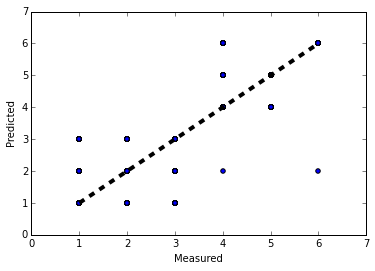

In [51]:
fig,ax = plt.subplots()
ax.scatter(y_train_np, predicted)
ax.plot([y_train_np.min(), y_train_np.max()], [y_train_np.min(), y_train_np.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')


# PCA

In [52]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

clf = RandomForestClassifier(n_estimators=20)

pca = decomposition.RandomizedPCA(n_components=10)
pipe = Pipeline(steps=[('pca', pca), ('forest', clf)])

X_train = StandardScaler().fit_transform(X_train_np) # Normalize data

pca.fit(X_train)

RandomizedPCA(copy=True, iterated_power=3, n_components=10, random_state=None,
       whiten=False)

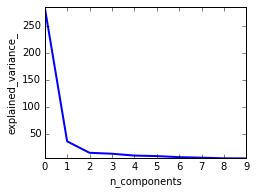

In [53]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [54]:
X = pca.transform(X_train_np)
clf.fit(X, y_train_np)

clf.score(pca.transform(X_test), y_test)

0.82897862232779096

In [55]:
scores = cross_validation.cross_val_score(
        clf, X, y_train_np, cv=10)

print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))  

Accuracy: 0.80 (+/- 0.09)


# LDA

In [58]:
from sklearn.lda import LDA


clf1 = LDA(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
clf2 = LDA(solver='lsqr', shrinkage=None).fit(X_train, y_train)

print(clf1.score(X_train, y_train)) # 45% accuracy.
print(clf2.score(X_train, y_train)) # ~99% accuracy!?

/home/thunder/anaconda3/envs/timeseries/lib/python3.3/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/thunder/anaconda3/envs/timeseries/lib/python3.3/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.449673558215
0.986262241567
